In [413]:
cd "nilm data\ukdale"

[WinError 3] The system cannot find the path specified: 'nilm data\\ukdale'
D:\jjenko\nilm data\ukdale


 Volume in drive D is Data
 Volume Serial Number is 3607-76B7

 Directory of D:\jjenko\nilm data\ukdale

08.03.2021  16:41    <DIR>          .
08.03.2021  16:41    <DIR>          ..
17.02.2021  15:30    <DIR>          .ipynb_checkpoints
08.03.2021  11:23            77.942 gasf.jpg
17.02.2021  19:54             4.956 ukdale parser.ipynb
05.03.2021  10:22     6.330.578.146 ukdale.h5
               3 File(s)  6.330.661.044 bytes
               3 Dir(s)  2.746.095.599.616 bytes free


In [441]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nilmtk
from nilmtk import DataSet, MeterGroup

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 10)
plt.figure(figsize=(10,30))

ukdale = DataSet('ukdale.h5')
ukdale.set_window(start='2013-3-15T1127',end='2013-3-15T1200')


<Figure size 720x2160 with 0 Axes>

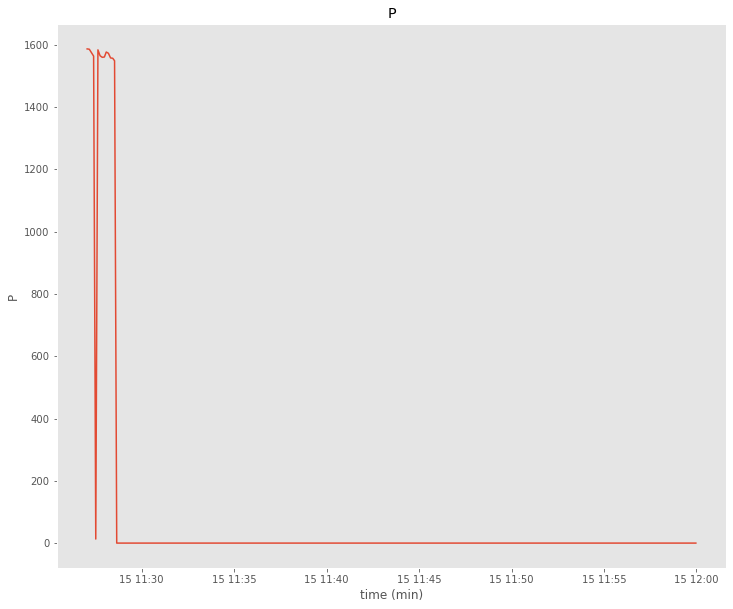

In [442]:
elec = ukdale.buildings[1].elec
fridge = elec['microwave']
fridge.available_columns()
df = next(fridge.load(physical_quantity='power'))

fig, ax = plt.subplots()
ax.plot(df.fillna(0))
ax.set(xlabel='time (min)', ylabel='P', title='P')
ax.grid()

#df.power.active[1900:1950]

In [435]:
df.axes

[DatetimeIndex(['2013-03-15 09:27:05+00:00', '2013-03-15 09:27:11+00:00',
                '2013-03-15 09:27:18+00:00', '2013-03-15 09:27:24+00:00',
                '2013-03-15 09:27:31+00:00', '2013-03-15 09:27:38+00:00',
                '2013-03-15 09:27:45+00:00', '2013-03-15 09:27:51+00:00',
                '2013-03-15 09:27:57+00:00', '2013-03-15 09:28:04+00:00',
                ...
                '2013-03-16 09:28:59+00:00', '2013-03-16 09:29:05+00:00',
                '2013-03-16 09:29:12+00:00', '2013-03-16 09:29:19+00:00',
                '2013-03-16 09:29:25+00:00', '2013-03-16 09:29:32+00:00',
                '2013-03-16 09:29:39+00:00', '2013-03-16 09:29:45+00:00',
                '2013-03-16 09:29:52+00:00', '2013-03-16 09:29:59+00:00'],
               dtype='datetime64[ns, Europe/London]', length=12361, freq=None),
 MultiIndex([('power', 'active')],
            names=['physical_quantity', 'type'])]

In [331]:
values = df.power.values
allZeros = np.all(values==0)
print(allZeros)


True


In [410]:
#cell is responsible for storing and handling with hdf5 data
import h5py

#if file does not exist create new one (M-n of months A-n of appliances)
file_name = "UKDALE_GAF_1h_12M10A300N"
# file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "w")
    

def create_hdf5_group(group_name): #groups are appliances such as fridge or toaster
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    dataset = file.create_group(f"{group_name}")
    file.close()


def store_single_hdf5(image, image_id, group_name): 
    """
    Stores single image to HDF5
    """     
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    group = file[f"{group_name}"]
    
    # Create a dataset in the file
    #"image", np.shape(image), h5py.h5t.STD_U8BE, data=image -> def guts
    dataset = g.create_dataset(f"{image_id}",np.shape(image))
        
   
    file.close()

def store_many_hdf5(images,group_name,image_set_name,**kwargs):
    """
    Stores multiple images to HDF5
    **kwargs(force_del="yes" to replace existing db w/o prompt)
    """     
    #define some parameters
    num_images = len(images)
    force_del_flag = kwargs.get('force_del', None)# we need it, if store many is frequently

    # read HDF5 file
    try:
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    except:
        print("file not found!")
    
    
    # open specified group
    try:
        group = file[f"{group_name}"]
    except:
        #if if does not exist create it
        group = file.create_group(f"{group_name}")
        

    #check if ds already exists, then prompt user
    for name in group:
        if str(name) == str(image_set_name):
            if force_del_flag == "yes":
                print("  removed "f"{name}""!")   
                del group[name]
            else:
                print("Dataset '"f"{name}" "' already exists in " f"{file_name}""/"f"{group_name}")
                
                ans = input("Do you want to replace existing dataset? (y,n) Press enter to contine")
                    
                if ans == "y":
                    print("  removed "f"{name}""!")   
                    del group[name]
                else:
                    print("  quiting! ") 
                    raise

    # Create a dataset in the group       
    print("storing... images to store: "f"{num_images}")
    dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.IEEE_F32LE , data=images)
   
    file.close()
    print("finshed. stored to " f"{file_name}""/"f"{group_name}""/"f"{image_set_name}")


def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.

    """
    images = []


    # Open the HDF5 file
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

In [6]:
#create new ds inside
#create_hdf5_group("fridge")
#store_many_hdf5(gasf_stack,"fridge","gasf")


In [390]:
#next 3 cells generate GAFs on based on manual selecont of interval
#select time range and period
step_in_hrs = 1
date_range = pd.date_range("2013-1-10T0000", "2014-1-1T0000",freq=''+str(step_in_hrs)+'h')
#print(date_range)

In [8]:
#(debug)graph first portion of the seleted range
# n = 18
# ukdale.set_window(start=date_range[n],end=date_range[n+1])
# elec = ukdale.buildings[1].elec
# fridge = elec['fridge']
# fridge.available_columns()
# df = next(fridge.load(physical_quantity='power'))
# print(len(df))
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set(xlabel='time (min)', ylabel='P', title='P')
# ax.grid()


In [408]:
file.close()

In [411]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
import numpy as np
import h5py

max_dataset_size = 300; #max number of images per appliance

manualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","oven","boiler","toaster","kettle","fridge"]
usefull_appliances = manualy_selected_appliances.copy()

for appliance in manualy_selected_appliances:
    print("\n")
    print("starting "f"{appliance} ("+str(manualy_selected_appliances.index(appliance)+1)+"/"+str(len(manualy_selected_appliances))+"):")
    
    #define some of the paramteres mainly for creating stack of images
    N_of_dates = len(date_range)-2
    #create 3D empty array to stack images into
    gasf_stack = np.empty([0,300,300])# -> change size to match GAF image size
    gadf_stack = np.empty([0,300,300])# -> change size to match GAF image size

    for interval in range(N_of_dates):

        try:
            ukdale.set_window(start=date_range[interval],end=date_range[interval+1])
        except:
            continue

        #try to read from dataset
        try:
            elec = ukdale.buildings[1].elec
            appliance_data = elec[appliance]
            #appliance_data.available_columns()
            df = next(appliance_data.load(physical_quantity='power'))
        except:
            #uncomment fo debug
            #print("problem, no data for "+appliance+"!")
            continue

        #do some metric calcs in order to determine if selected window needs to be dropped
        metric = (3600*step_in_hrs)/6 #will adjust automaticly
        if len(df) <= 0.8*metric:# -> manulay select %
            #uncomment for debug
            #print("skipped iteration: "+str(date_range[interval])+" had only "+str(len(df))+" out of "+str(metric)+" points ("+str(int(100*(len(df))/metric))+"%)")
            continue 
        
        #check if all values in an array are equal to 0
        values = df.power.values
        All_zero = np.all(values==0)  
        All_ones = np.all(values==1)  
        All_equal = np.all(values==values[0])
        if All_zero == True or All_ones == True or All_equal == True:
            #print("skipped due all zero or all one")
            #if all values are 0 then skip
            continue

        #check if dataset size is larger than specified
        if gasf_stack.shape[0] >= max_dataset_size:
            print("max DS size reached size of "f"{max_dataset_size}"", skipping!")   
            break

        #do some reshaping to satisfy GAF library
        S = df.fillna(0).to_numpy().reshape(1,-1)
        Ssmall= S[0,0:S.size]
        S2d = np.reshape(Ssmall, (1, S.size))

        # Transform the time series into Gramian Angular Fields
        gasf = GramianAngularField(image_size=300, method='summation')
        X_gasf = gasf.fit_transform(S2d)
        gadf = GramianAngularField(image_size=300, method='difference')
        X_gadf = gadf.fit_transform(S2d)

        gasf_stack = np.append(gasf_stack,X_gasf,axis=0)
        gadf_stack = np.append(gadf_stack,X_gadf,axis=0)
        
        print("\r",round(100*interval/(N_of_dates-1),2)," % complete         ",end="")

    print("")
    print("number of images (per dataset) stacked: "f"{gasf_stack.shape[0]}"" out of all possible " f"{N_of_dates}" " ("f"{int(100*gasf_stack.shape[0]/N_of_dates)}""%)")
    if gasf_stack.shape[0] > 0:
        store_many_hdf5(gasf_stack,f"{appliance}","gasf",force_del="yes")
        store_many_hdf5(gadf_stack,f"{appliance}","gadf",force_del="yes")
    else:
        usefull_appliances.remove(appliance)
        print("nothing to store!")
    
    print("finished "f"{appliance}")
    
    print("\n")
    
   



starting computer monitor (1/10):
 27.64  % complete         max DS size reached size of 300, skipping!

number of images (per dataset) stacked: 300 out of all possible 8543 (3%)
storing... images to store: 300
finshed. stored to UKDALE_GAF_1h_12M10A300N/computer monitor/gasf
storing... images to store: 300
finshed. stored to UKDALE_GAF_1h_12M10A300N/computer monitor/gadf
finished computer monitor




starting laptop computer (2/10):
 18.92  % complete         max DS size reached size of 300, skipping!

number of images (per dataset) stacked: 300 out of all possible 8543 (3%)
storing... images to store: 300
finshed. stored to UKDALE_GAF_1h_12M10A300N/laptop computer/gasf
storing... images to store: 300
finshed. stored to UKDALE_GAF_1h_12M10A300N/laptop computer/gadf
finished laptop computer




starting television (3/10):
 7.14  % complete         max DS size reached size of 300, skipping!

number of images (per dataset) stacked: 300 out of all possible 8543 (3%)
storing... images to

In [383]:
manualy_selected_appliances = ["computer monitor", "laptop computer", "televison", "washer dryer", "microwave","oven","boiler","toaster","kettle"]
usefull_appliances = manualy_selected_appliances.copy()
usefull_appliances.remove("televison")
print(usefull_appliances)

['computer monitor', 'laptop computer', 'washer dryer', 'microwave', 'oven', 'boiler', 'toaster', 'kettle']


-0.9137141258843868

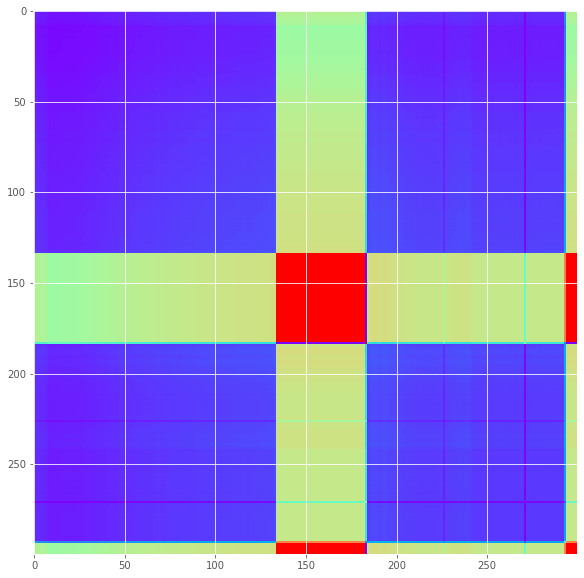

In [111]:
# Show image to be saved
fig, ax = plt.subplots()
ax.imshow(gasf_stack[129], cmap='rainbow')
gasf_stack[129][50][50]

In [107]:
#store images generated above
store_many_hdf5(gasf_stack,"fridge","gasf")

Dataset 'gasf' already exists in UKDALE_GAF_1h/fridge
  removed gasf!
storing... images to store: 327
finshed. stored to UKDALE_GAF_1h/fridge/gasf


In [415]:
#retrieve stored images
ret_img_stack = read_many_hdf5("toaster","gasf")
ret_img_stack_fridge = read_many_hdf5("fridge","gasf")
ret_img_stack.shape


(300, 300, 300)

1.0

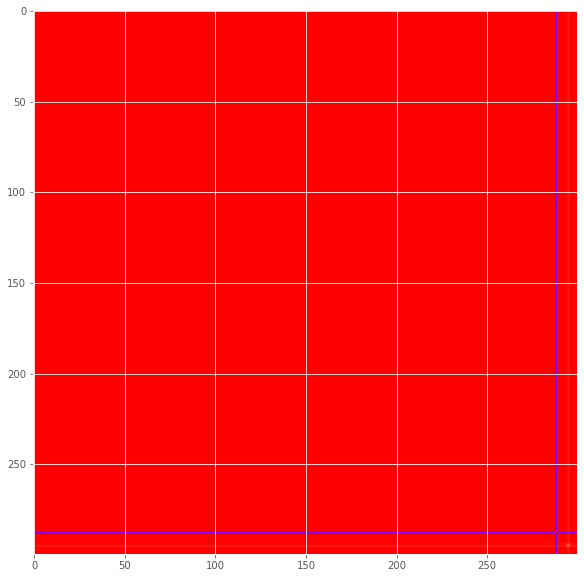

In [416]:
# Show retrieved image
fig, ax = plt.subplots()
ax.imshow(ret_img_stack[3], cmap='rainbow')
ax.imshow(ret_img_stack[3], cmap='rainbow')
ax.imshow(ret_img_stack[2], cmap='rainbow')

ret_img_stack[1][50][50]

In [273]:
appl = elec.appliances
num_of_appliances = len(appl)
import time
manualy_selected_appliances = ["computer", "computer monitor", "laptop computer", "televison", "washer dryer", "coffee maker", "microwave" ]

# for appliance in manualy_selected_appliances:
 
#  try:
#     applianceD = elec[appliance]
#  except:
#     #print("problem")
#     continue
#  time.sleep(1)
#  print("\r",100*manualy_selected_appliances.index(appliance)/(len(manualy_selected_appliances)-1)," percent complete         ",end="")


#select window and check quality of data in the window
ukdale.set_window(start='2013-1-8T0920',end='2013-3-1T1200')


for i in range(num_of_appliances):

   appl[i] = appl[i].type["type"]

   try:
      elec = ukdale.buildings[1].elec
      appliance_data = elec[appl[i]]
      #appliance_data.available_columns()
      df = next(appliance_data.load(physical_quantity='power'))
   except:
      print("problem, no data for "+appliance+"!")
      continue
   print(appl[i]) 

oven
laptop computer
active subwoofer
boiler
ethernet switch
fan
soldering iron
broadband router
mobile phone charger
hair dryer
audio amplifier
light
light
drill
food processor
toaster
washer dryer
light
HTPC
radio
light
light
fridge freezer
baby monitor
laptop computer
water pump
security alarm
broadband router
toasted sandwich maker
coffee maker
USB hub
light
dish washer
vacuum cleaner
light
computer
light
radio
light
light
kettle
audio system
kitchen aid
clothes iron
computer monitor
television
baby monitor
solar thermal pumping station
wireless phone charger
desktop computer
light
printer
immersion heater
laptop computer
fan
charger
mobile phone charger
tablet computer charger
microwave
light
food processor
bouncy castle pump
light
light
breadmaker
light
hair straighteners
radio
external hard disk
washer dryer
light
audio system


In [412]:
file.close()